In [22]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd 
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm, ols
import statsmodels.formula.api as smf
from astropy.stats import circcorrcoef
from statsmodels.stats.multitest import multipletests
import pingouin as pg

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) * (sess_df['dark']==0))]

sess_df = sess_df.loc[sess_df['rnai_line '] != 'rnai_76062']

rnai = []
for _, row in sess_df.iterrows():
    if row['gal4_line']!='control':
        rnai.append(row['rnai_line '])
    else:
        rnai.append('gal4_control')
sess_df['rnai']=rnai


Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [3]:
sess_df.head()

date   fly             sess fictrac_scan_num  closed_loop  dark  \
0  29_03_2024  fly2  closed_loop-000                0            1     0   
1  29_03_2024  fly2         dark-001                1            0     1   
2  29_03_2024  fly2  closed_loop-002                2            2     0   
3  29_03_2024  fly2         dark-003                3            0     1   
5  01_04_2024  fly1  closed_loop-000                0            1     0   

   rnai_line  gal4_line  usable             fictrac_dat_file notes  \
0  rnai_67968    R18B05       1  fictrac-20240329_135950.dat   NaN   
1  rnai_67968    R18B05       1  fictrac-20240329_135950.dat   NaN   
2  rnai_67968    R18B05       1  fictrac-20240329_135950.dat   NaN   
3  rnai_67968    R18B05       1  fictrac-20240329_135950.dat   NaN   
5  rnai_67968    R18B05       1  fictrac-20240401_162130.dat   NaN   

                              fly_id        rnai  
0  29_03_2024_fly2_R18B05_rnai_67968  rnai_67968  
1  29_03_2024_fly2_R18B05_rnai_67968  rnai_67968  
2  29_03_2024_fly2_R18B05_rnai_67968  rnai_67968  
3  29_03_2024_fly2_R18B05_rnai_67968  rnai_67968  
5  01_04_2024_fly1_R18B05_rnai_67968  rnai_67968

In [4]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['rnai'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)
        
    

In [5]:
stats_df = nmp.tbh_rnai.offset_stats(sess_df, load_row)
stats_df_unique = nmp.tbh_rnai.offset_stats_unique(stats_df)
stats_df_plot = nmp.tbh_rnai.offset_stats_plot(stats_df_unique)

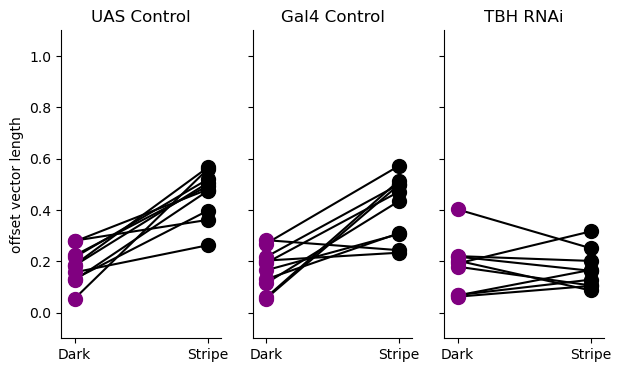

In [6]:
fig,ax = plt.subplots(1,3,sharey=True, figsize=[7,4])

c_df = stats_df_plot.loc[stats_df_plot['rnai']=='control']
ax[0].set_title('UAS Control')
# ax[0].plot([0,1], c_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black', zorder=-1)
# ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_var_dark'], color='purple', alpha=1, s=100)
# ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_var_closed_loop'], color='black', alpha=1, s=100)
ax[0].plot([0,1], c_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)

gal4_df = stats_df_plot.loc[stats_df_plot['rnai']=='gal4_control']
ax[1].set_title('Gal4 Control')
# ax[1].plot([0,1], gal4_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black', zorder=-1)
# ax[1].scatter(np.zeros((gal4_df.shape[0],)), gal4_df['offset_var_dark'], color='purple', alpha=1, s=100)
# ax[1].scatter(np.ones((gal4_df.shape[0],)), gal4_df['offset_var_closed_loop'], color='black', alpha=1, s=100)
ax[1].plot([0,1], gal4_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[1].scatter(np.zeros((gal4_df.shape[0],)), gal4_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[1].scatter(np.ones((gal4_df.shape[0],)), gal4_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)

tbh_df = stats_df_plot.loc[stats_df_plot['rnai']=='rnai_67968']
ax[2].set_title('TBH RNAi')
# ax[2].plot([0,1], tbh_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black', zorder=-1)
# ax[2].scatter(np.zeros((tbh_df.shape[0],)), tbh_df['offset_var_dark'], color='purple', alpha=1, s=100)
# ax[2].scatter(np.ones((tbh_df.shape[0],)), tbh_df['offset_var_closed_loop'], color='black', alpha=1, s=100)
ax[2].plot([0,1], tbh_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[2].scatter(np.zeros((tbh_df.shape[0],)), tbh_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[2].scatter(np.ones((tbh_df.shape[0],)), tbh_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)


for _ax in ax:
    _ax.set_ylim([-0.1,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([0,.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('offset vector length')


fig.savefig(figfolder / 'offset_mag_summary.pdf', format='pdf')

In [7]:
from pingouin import mixed_anova, pairwise_tests
aov = mixed_anova(dv='offset_var_logit', between='rnai',
                  within='dark', subject='fly_id', data=stats_df_unique.loc[stats_df_unique['rnai']!='rnai_76062'])
aov

Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0         rnai   6.768731    2   26   3.384365   9.642038  0.000737  0.425847   
1         dark  13.052490    1   26  13.052490  37.580948  0.000002  0.591072   
2  Interaction   5.636634    2   26   2.818317   8.114546  0.001827  0.384311   

   eps  
0  NaN  
1  1.0  
2  NaN

In [8]:
tt = pairwise_tests(dv='offset_var_logit', between='rnai',
                   subject='fly_id', within='dark', data=stats_df_unique.loc[stats_df_unique['rnai']!='rnai_76062'],
                   padjust='holm', parametric=True, interaction=True, within_first=False)

print(tt['Contrast'].unique())
tt

['rnai' 'dark' 'rnai * dark']


Contrast          rnai             A             B Paired  Parametric  \
0         rnai             -       control  gal4_control  False        True   
1         rnai             -       control    rnai_67968  False        True   
2         rnai             -  gal4_control    rnai_67968  False        True   
3         dark             -             0             1   True        True   
4  rnai * dark       control             0             1   True        True   
5  rnai * dark  gal4_control             0             1   True        True   
6  rnai * dark    rnai_67968             0             1   True        True   

          T        dof alternative     p-unc    p-corr p-adjust     BF10  \
0 -1.261845  18.000000   two-sided  0.223111  0.223111     holm    0.689   
1 -3.830162  12.179790   two-sided  0.002333  0.007000     holm   23.688   
2 -2.847357  13.258663   two-sided  0.013503  0.027007     holm    4.806   
3 -4.991798  28.000000   two-sided  0.000028       NaN      NaN  819.032   
4 -5.946566   9.000000   two-sided  0.000216  0.000649     holm  148.125   
5 -4.243838   9.000000   two-sided  0.002162  0.004324     holm   21.557   
6 -0.086315   8.000000   two-sided  0.933337  0.933337     holm    0.323   

     hedges  
0 -0.540470  
1 -1.731771  
2 -1.280009  
3 -1.267028  
4 -2.771269  
5 -2.082158  
6 -0.029782

In [9]:
tt = pairwise_tests(dv='offset_var', between='rnai',
                   subject='fly_id', within='dark', data=stats_df_unique.loc[stats_df_unique['rnai']!='rnai_76062'],
                   padjust='holm', parametric=True, interaction=True, within_first=True)

print(tt['Contrast'].unique())
print(tt['p-corr'])
tt

['dark' 'rnai' 'dark * rnai']
0         NaN
1    0.219764
2    0.001017
3    0.007245
4    1.000000
5    0.000006
6    0.000591
7    1.000000
8    1.000000
9    1.000000
Name: p-corr, dtype: float64


Contrast dark             A             B Paired  Parametric         T  \
0         dark    -             0             1   True        True -5.240867   
1         rnai    -       control  gal4_control  False        True -1.271419   
2         rnai    -       control    rnai_67968  False        True -4.707208   
3         rnai    -  gal4_control    rnai_67968  False        True -3.423118   
4  dark * rnai    0       control  gal4_control  False        True -1.080174   
5  dark * rnai    0       control    rnai_67968  False        True -7.451817   
6  dark * rnai    0  gal4_control    rnai_67968  False        True -5.136246   
7  dark * rnai    1       control  gal4_control  False        True -0.442442   
8  dark * rnai    1       control    rnai_67968  False        True -0.111375   
9  dark * rnai    1  gal4_control    rnai_67968  False        True  0.231069   

         dof alternative     p-unc    p-corr p-adjust       BF10    hedges  
0  28.000000   two-sided  0.000014       NaN      NaN   1524.054 -1.357146  
1  18.000000   two-sided  0.219764  0.219764     holm      0.695 -0.544571  
2  13.960422   two-sided  0.000339  0.001017     holm    108.373 -2.108137  
3  15.505691   two-sided  0.003622  0.007245     holm     11.976 -1.519333  
4  18.000000   two-sided  0.294326  1.000000     holm      0.597 -0.462657  
5  16.803515   two-sided  0.000001  0.000006     holm  1.113e+04 -3.231189  
6  15.142187   two-sided  0.000118  0.000591     holm    229.614 -2.198337  
7  18.000000   two-sided  0.663440  1.000000     holm      0.426 -0.189506  
8  13.514445   two-sided  0.912956  1.000000     holm      0.406 -0.049999  
9  14.637287   two-sided  0.820460  1.000000     holm      0.412  0.103098

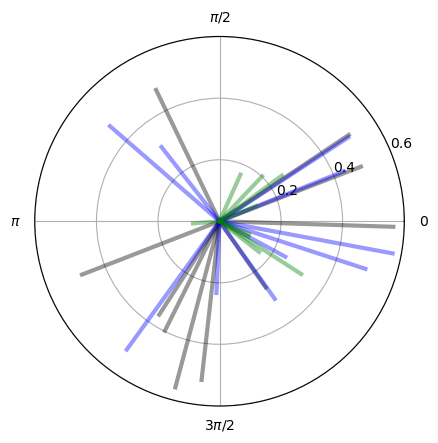

In [10]:


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

offsets = stats_df_unique.loc[(stats_df_unique['rnai']=='control') * (stats_df_unique['dark']==0),'offset_mean']#-np.pi
mag = stats_df_unique.loc[(stats_df_unique['rnai']=='control') * (stats_df_unique['dark']==0),'offset_mag']

for i, (o,m) in enumerate(zip(offsets.tolist(),mag.tolist())):
    # print(o,m)
    ax.plot([o,o],[0,m], linewidth=3, color='black',alpha=.4)
    
offsets = stats_df_unique.loc[(stats_df_unique['rnai']=='gal4_control') * (stats_df_unique['dark']==0),'offset_mean']#-np.pi
mag = stats_df_unique.loc[(stats_df_unique['rnai']=='gal4_control') * (stats_df_unique['dark']==0),'offset_mag']

for i, (o,m) in enumerate(zip(offsets.tolist(),mag.tolist())):
    # print(o,m)
    ax.plot([o,o],[0,m], linewidth=3, color='blue', alpha=.4)

offsets = stats_df_unique.loc[(stats_df_unique['rnai']=='rnai_67968') * (stats_df_unique['dark']==0),'offset_mean']#-np.pi
mag = stats_df_unique.loc[(stats_df_unique['rnai']=='rnai_67968') * (stats_df_unique['dark']==0),'offset_mag']

for i, (o,m) in enumerate(zip(offsets.tolist(),mag.tolist())):
    # print(o,m)
    ax.plot([o,o],[0,m], linewidth=3, color='green', alpha=.4)

    
_ = ax.set_rticks([.2, .4, .6])
_ = ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    

fig.savefig(figfolder / 'offset_hist_summary.pdf', format='pdf')

### Compare bump amplitude vs speed for all flies

In [11]:
dh_bins = np.linspace(.0, 3.14, num=20)

stats_df = nmp.tbh_rnai.rho_stats(sess_df, load_row, dh_bins=dh_bins)

stats_df = stats_df.loc[stats_df['cl']!=1] # exclude first closed loop session
stats_df.loc[stats_df['cl']>1, 'cl'] = 1 #
stats_df.loc[stats_df['dark']>=1, 'dark'] = 1 # 

grouped = stats_df.groupby(['fly_id','dark','rnai'])['rho_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))
grouped = grouped.reset_index()

grouped.head()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/e

fly_id  dark        rnai  \
0  01_04_2024_fly1_R18B05_rnai_67968     0  rnai_67968   
1  01_04_2024_fly1_R18B05_rnai_67968     1  rnai_67968   
2     02_04_2024_fly2_R18B05_control     0     control   
3     02_04_2024_fly2_R18B05_control     1     control   
4  03_04_2024_fly1_R18B05_rnai_67968     0  rnai_67968   

                                             rho_dig  
0  [0.27117099499939856, 0.35426642177505313, 0.4...  
1  [0.3102485638141095, 0.5413655504934706, 0.555...  
2  [0.34902172495916484, 0.4373659962009303, 0.44...  
3  [0.3199787975080455, 0.34461866896932825, 0.35...  
4  [0.19088912477182574, 0.20382579957789626, 0.2...

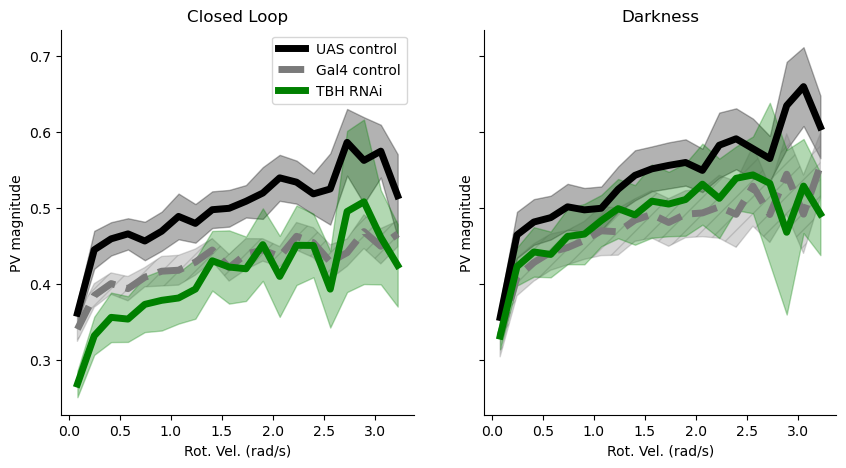

In [12]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2
conditions = ('control','gal4_control', 'rnai_67968') 
rho_dict = {}
for cond in conditions:
    rho_dict[cond] = {'dark_rho':[],
                      'cl_rho':[]}

for fly in grouped['fly_id'].unique():
    if (grouped['fly_id']==fly).sum()>1:
        
        cond = grouped.loc[grouped['fly_id']==fly,'rnai'].iloc[0]
        
        dark_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'rho_dig']
        cl_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'rho_dig']
        
        
        rho_dict[cond]['dark_rho'].append(dark_rho.iloc[0])
        rho_dict[cond]['cl_rho'].append(cl_rho.iloc[0])

for cond in conditions:
    rho_dict[cond]['dark_rho'] = np.stack(rho_dict[cond]['dark_rho'])
    rho_dict[cond]['cl_rho'] = np.stack(rho_dict[cond]['cl_rho'])


fig, ax= plt.subplots(1,2, figsize=[10,5], sharey=True)
mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(rho_dict['gal4_control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['gal4_control']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label ='Gal4 control', linestyle='--')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', linewidth=5, label = 'TBH RNAi')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)


ax[0].legend()


mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='black', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(rho_dict['gal4_control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['gal4_control']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label ='Gal4 control', linestyle='--')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(rho_dict['rnai_67968']['dark_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)



for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Rot. Vel. (rad/s)')
    a.set_ylabel('PV magnitude')
ax[0].set_title('Closed Loop')
ax[1].set_title('Darkness')

fig.savefig(figfolder / 'PVMag_v_RotVel.pdf', format='pdf')
    

In [13]:
h,p = sp.stats.kruskal(np.nanmean(rho_dict['control']['cl_rho'],axis=-1), 
                       np.nanmean(rho_dict['gal4_control']['cl_rho'],axis=-1),
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(h,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['control']['cl_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(t,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['gal4_control']['cl_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['cl_rho'], axis=-1))
print(t,p)


5.320197044334975 0.06994133063370636
60.0 0.08313908313908314
44.0 0.7618264088852323


In [14]:
h,p = sp.stats.kruskal(np.nanmean(rho_dict['control']['dark_rho'],axis=-1), 
                       np.nanmean(rho_dict['gal4_control']['dark_rho'],axis=-1),
                            np.nanmean(rho_dict['rnai_67968']['dark_rho'], axis=-1))
print(h,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['control']['dark_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['dark_rho'], axis=-1))
print(t,p)

t,p = sp.stats.mannwhitneyu(np.nanmean(rho_dict['gal4_control']['dark_rho'],axis=-1), 
                            np.nanmean(rho_dict['rnai_67968']['dark_rho'], axis=-1))
print(t,p)


1.8679802955664968 0.392982519485319
51.0 0.35993418346359524
37.0 0.8285570638511814


In [18]:
# reformat for regression
reg_df = nmp.tbh_rnai.reformat_rho_stats_for_reg(grouped, dh_bins)
reg_df['log_rho'] = np.log(reg_df['rho']+1e-6)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

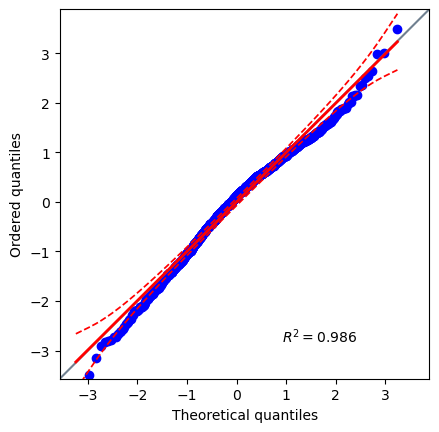

In [24]:
pg.qqplot(reg_df['log_rho'])

In [19]:
from pingouin import mixed_anova, pairwise_tests
aov = mixed_anova(dv='log_rho', between='rnai',
                  within='dh', subject='fly_id', data=reg_df.loc[reg_df['dark']==0])
aov

Source        SS  DF1  DF2        MS          F         p-unc  \
0         rnai  6.298733    2   22  3.149367   4.271080  2.708647e-02   
1           dh  4.465606   19  418  0.235032  23.931691  3.325825e-55   
2  Interaction  0.590099   38  418  0.015529   1.581203  1.782596e-02   

        np2      eps  
0  0.279684      NaN  
1  0.521028  0.34692  
2  0.125680      NaN

In [21]:
tt = pairwise_tests(dv='log_rho', between='rnai',
                   subject='fly_id', within='dh', data=reg_df.loc[reg_df['dark']==0],
                   padjust='holm', parametric=True, interaction=True, within_first=False)

print(tt['Contrast'].unique())
# tt
tt.loc[tt['Contrast']=='dh * rnai']

['rnai' 'dh' 'rnai * dh']


Empty DataFrame
Columns: [Contrast, rnai, A, B, Paired, Parametric, T, dof, alternative, p-unc, p-corr, p-adjust, BF10, hedges]
Index: []

In [46]:
tt = pairwise_tests(dv='rho', between='rnai',
                   subject='fly_id', within='dh', data=reg_df.loc[reg_df['dark']==0],
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

Contrast        rnai             A             B Paired  Parametric  \
0         rnai           -       control  gal4_control  False        True   
1         rnai           -       control    rnai_67968  False        True   
2         rnai           -  gal4_control    rnai_67968  False        True   
3           dh           -           0.0      0.165263   True        True   
4           dh           -           0.0      0.330526   True        True   
..         ...         ...           ...           ...    ...         ...   
758  rnai * dh  rnai_67968      2.644211      2.974737   True        True   
759  rnai * dh  rnai_67968      2.644211          3.14   True        True   
760  rnai * dh  rnai_67968      2.809474      2.974737   True        True   
761  rnai * dh  rnai_67968      2.809474          3.14   True        True   
762  rnai * dh  rnai_67968      2.974737          3.14   True        True   

            T        dof alternative         p-unc    p-corr p-adjust  \
0    2.433764  12.035253   two-sided  3.146149e-02  0.094384     holm   
1    2.214323   8.830642   two-sided  5.461710e-02  0.109234     holm   
2    0.857494   6.049512   two-sided  4.238354e-01  0.423835     holm   
3   -7.262207  24.000000   two-sided  1.673912e-07  0.000029     holm   
4   -8.631666  24.000000   two-sided  8.011475e-09  0.000001     holm   
..        ...        ...         ...           ...       ...      ...   
758 -1.739179   5.000000   two-sided  1.424957e-01  1.000000     holm   
759 -0.609466   5.000000   two-sided  5.688450e-01  1.000000     holm   
760 -0.102610   5.000000   two-sided  9.222608e-01  1.000000     holm   
761  1.310720   5.000000   two-sided  2.469239e-01  1.000000     holm   
762  2.083758   5.000000   two-sided  9.162344e-02  1.000000     holm   

          BF10    hedges  
0        2.633  1.101263  
1        1.883  1.162157  
2        0.556  0.508313  
3    9.334e+04 -0.801389  
4    1.585e+06 -1.028642  
..         ...       ...  
758      0.994 -0.530198  
759      0.434 -0.110231  
760      0.375 -0.021754  
761      0.691  0.327985  
762      1.352  0.417591  

[763 rows x 14 columns]

In [47]:
tt = pairwise_tests(dv='rho', between='rnai',
                   subject='fly_id', within='dark', data=reg_df,
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

Contrast          rnai             A             B Paired  Parametric  \
0         rnai             -       control  gal4_control  False        True   
1         rnai             -       control    rnai_67968  False        True   
2         rnai             -  gal4_control    rnai_67968  False        True   
3         dark             -             0             1   True        True   
4  rnai * dark       control             0             1   True        True   
5  rnai * dark  gal4_control             0             1   True        True   
6  rnai * dark    rnai_67968             0             1   True        True   

          T        dof alternative     p-unc    p-corr p-adjust     BF10  \
0  2.010607  18.000000   two-sided  0.059592  0.178777     holm    1.517   
1  1.489531  12.437331   two-sided  0.161263  0.322527     holm    0.864   
2  0.098059  10.613067   two-sided  0.923713  0.923713     holm    0.415   
3 -4.475479  27.000000   two-sided  0.000125       NaN      NaN  215.818   
4 -2.756658   9.000000   two-sided  0.022233  0.044467     holm    3.291   
5 -1.899263   9.000000   two-sided  0.089994  0.089994     holm    1.139   
6 -3.619427   7.000000   two-sided  0.008517  0.025550     holm     7.41   

     hedges  
0  0.861178  
1  0.697954  
2  0.047023  
3 -0.542341  
4 -0.443775  
5 -0.589915  
6 -0.610932

Correlation of bump movement with turning in darkness vs closed loop


In [25]:
dh_bins = np.linspace(-2, 2, num=20)
stats_df = nmp.tbh_rnai.dphi_stats(sess_df, load_row, dh_bins)


stats_df = stats_df.loc[stats_df['cl']!=1] # exclude first closed loop session
stats_df.loc[stats_df['cl']>1, 'cl'] = 1 #
stats_df.loc[stats_df['dark']>=1, 'dark'] = 1 # 

grouped = stats_df.groupby(['fly_id','dark','rnai'])['dphi_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))

grouped = grouped.reset_index()
    


/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:198: RuntimeWarning: Mean of empty slice.
  dphi_dig = np.array([d_phi[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:198: RuntimeWarning: Mean of empty slice.
  dphi_dig = np.array([d_phi[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:198: RuntimeWarning: Mean of empty slice.
  dphi_dig = np.array([d_phi[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/e

control
gal4_control
rnai_67968


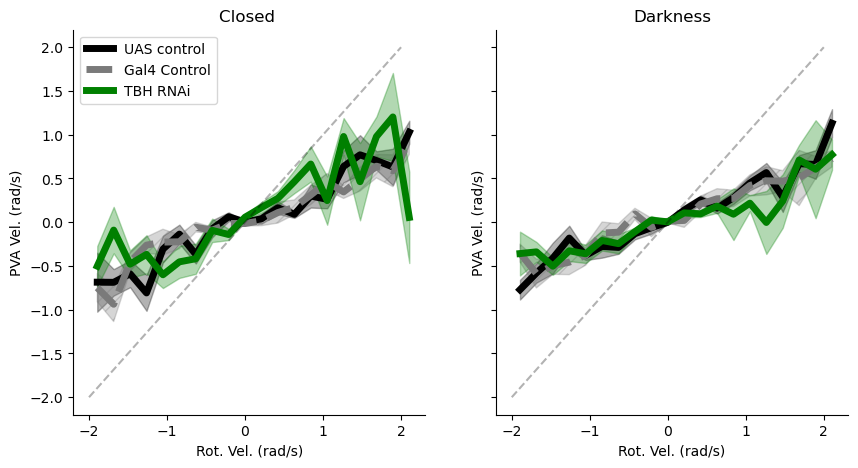

In [26]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2
conditions = ('control','gal4_control', 'rnai_67968') 
dphi_dict = {}
for cond in conditions:
    dphi_dict[cond] = {'dark_dphi':[],
                      'cl_dphi':[]}

for fly in grouped['fly_id'].unique():
    if (grouped['fly_id']==fly).sum()>1:
        
        cond = grouped.loc[grouped['fly_id']==fly,'rnai'].iloc[0]
        
        dark_dphi = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'dphi_dig']
        cl_dphi = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'dphi_dig']
        
        dphi_dict[cond]['dark_dphi'].append(dark_dphi.iloc[0])
        dphi_dict[cond]['cl_dphi'].append(cl_dphi.iloc[0])
        
for cond in conditions:
    print(cond)
    dphi_dict[cond]['dark_dphi'] = np.stack(dphi_dict[cond]['dark_dphi'])
    dphi_dict[cond]['cl_dphi'] = np.stack(dphi_dict[cond]['cl_dphi'])


fig, ax= plt.subplots(1,2, figsize=[10,5], sharey=True)
mu,sem = np.nanmean(dphi_dict['control']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['control']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(dphi_dict['gal4_control']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['gal4_control']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label='Gal4 Control', linestyle='--')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(dphi_dict['rnai_67968']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['rnai_67968']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', linewidth=5, label='TBH RNAi')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)

ax[0].legend()

mu,sem = np.nanmean(dphi_dict['control']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['control']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='black', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(dphi_dict['gal4_control']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['gal4_control']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label='Gal4 Control', linestyle='--')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')



mu,sem = np.nanmean(dphi_dict['rnai_67968']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['rnai_67968']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)


for a in ax:
    
    a.plot([-2,2],[-2,2], 'k--', alpha=.3)
    # a.set_ylim([-1,1])
    # a.set_xlim([-1,1])
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Rot. Vel. (rad/s)')
    a.set_ylabel('PVA Vel. (rad/s)')
    
ax[0].set_title('Closed ')
ax[1].set_title('Darkness')

fig.savefig(figfolder / 'dPVA_v_RotVel.pdf', format='pdf')
    
    
    


In [27]:
reg_df = nmp.tbh_rnai.reformat_dphi_stats_for_reg(grouped, dh_bins)



In [29]:
df = reg_df.loc[reg_df['dark']==0]
# model = mixedlm('dphi ~ C(rnai, Treatment("rnai_67968"))*dh', df, groups=df['fly_id'])
# model = ols('dphi ~ dh*C(rnai, Treatment("rnai_67968"))-C(rnai, Treatment("rnai_67968"))', df)
model = ols('dphi ~ dh*C(rnai, Treatment("rnai_67968"))', df)

result = model.fit()
print(result.summary())
print(result.pvalues)
hypotheses = '(dh:C(rnai, Treatment("rnai_67968"))[T.control] = 0), (dh:C(rnai, Treatment("rnai_67968"))[T.gal4_control] = 0)'
print(result.wald_test(hypotheses))
hypotheses = '(C(rnai, Treatment("rnai_67968"))[T.control] = 0), (C(rnai, Treatment("rnai_67968"))[T.gal4_control] = 0)'
print(result.wald_test(hypotheses))
# intxns = ['C(rnai, Treatment("rnai_67968"))[T.control]:dh',
#        'C(rnai, Treatment("rnai_67968"))[T.gal4_control]:dh']

# intxn_pvals = [result.pvalues[k] for k in intxns]
# print(multipletests(intxn_pvals , alpha=.05, method='holm'))


                            OLS Regression Results                            
Dep. Variable:                   dphi   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     84.66
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           5.97e-66
Time:                        22:54:24   Log-Likelihood:                -430.91
No. Observations:                 558   AIC:                             873.8
Df Residuals:                     552   BIC:                             899.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [53]:
df = reg_df.loc[reg_df['dark']==1]
# model = mixedlm('dphi ~ C(rnai, Treatment("rnai_67968"))*dh', df, groups=df['fly_id'])
model = ols('dphi ~ C(rnai, Treatment("rnai_67968"))*dh', df)

result = model.fit()
print(result.summary())
print(result.pvalues)

intxns = ['C(rnai, Treatment("rnai_67968"))[T.control]:dh',
       'C(rnai, Treatment("rnai_67968"))[T.gal4_control]:dh']

intxn_pvals = [result.pvalues[k] for k in intxns]
print(multipletests(intxn_pvals , alpha=.05, method='holm'))

                            OLS Regression Results                            
Dep. Variable:                   dphi   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     68.79
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           4.36e-57
Time:                        18:03:05   Log-Likelihood:                -480.03
No. Observations:                 620   AIC:                             972.1
Df Residuals:                     614   BIC:                             998.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:322: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[8,4])


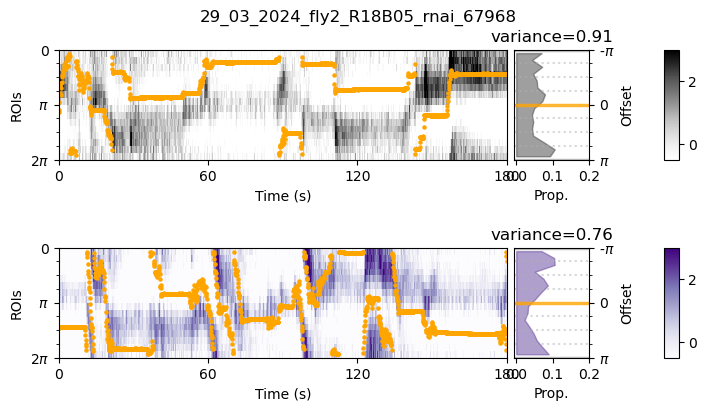

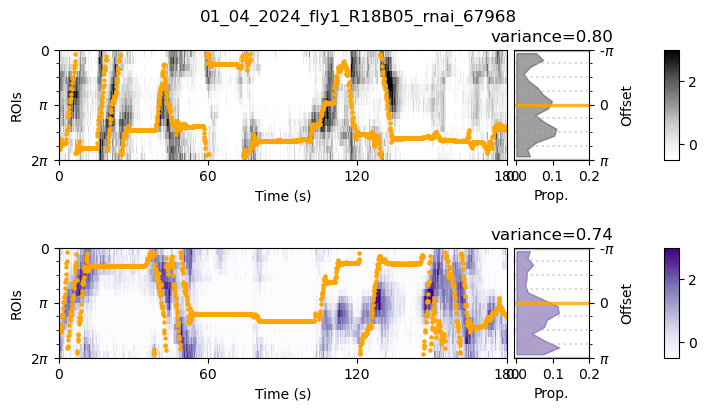

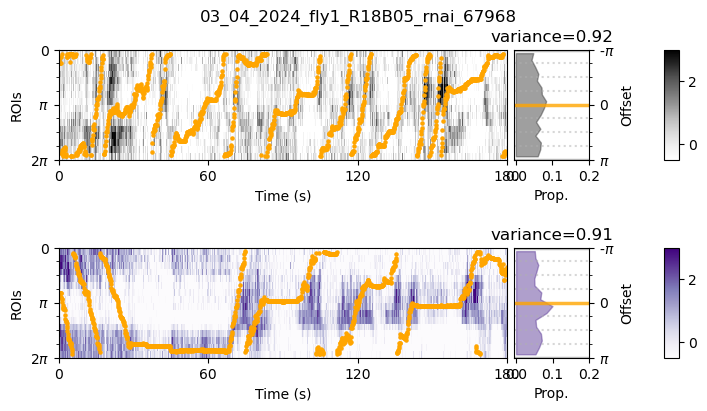

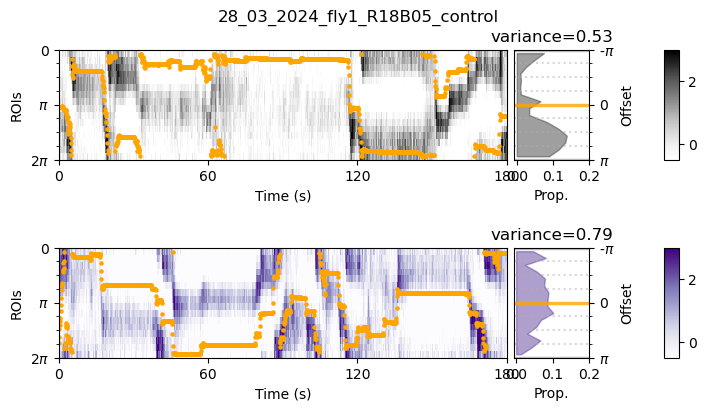

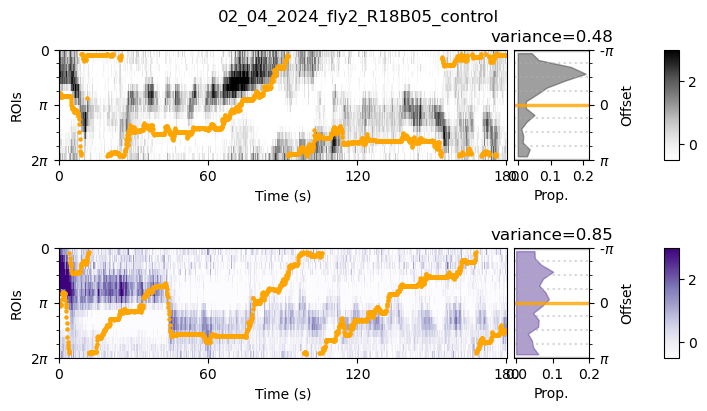

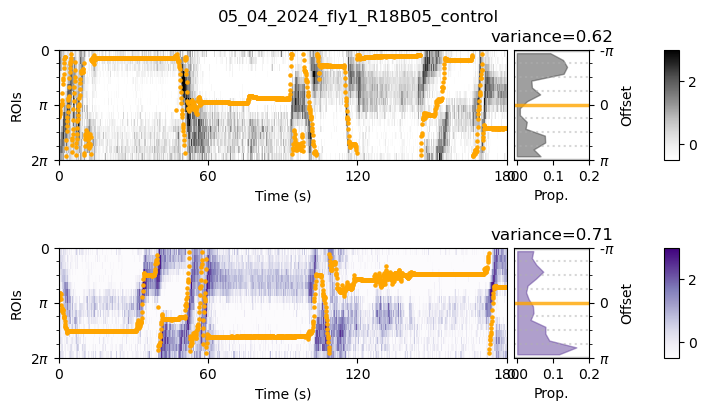

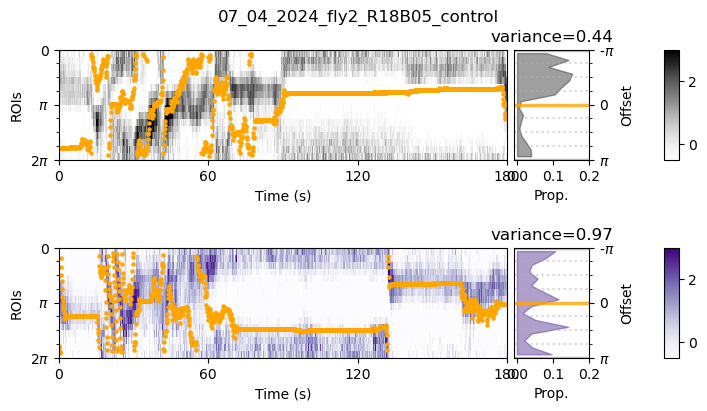

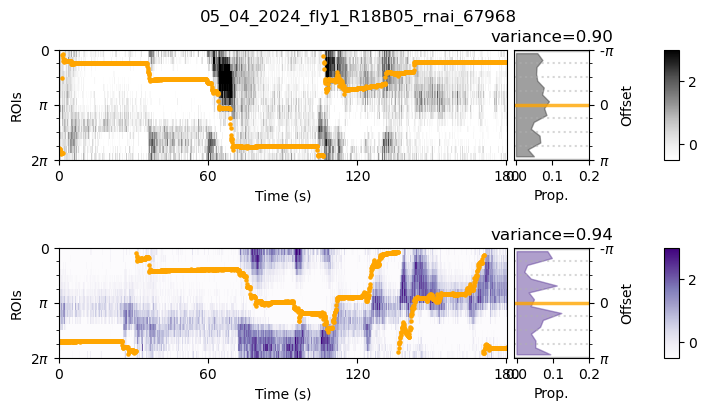

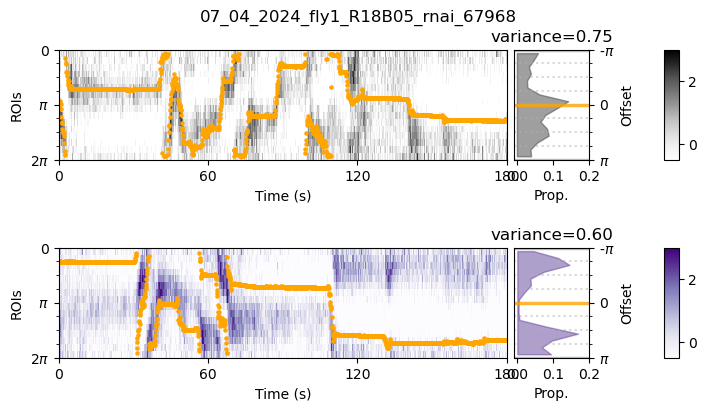

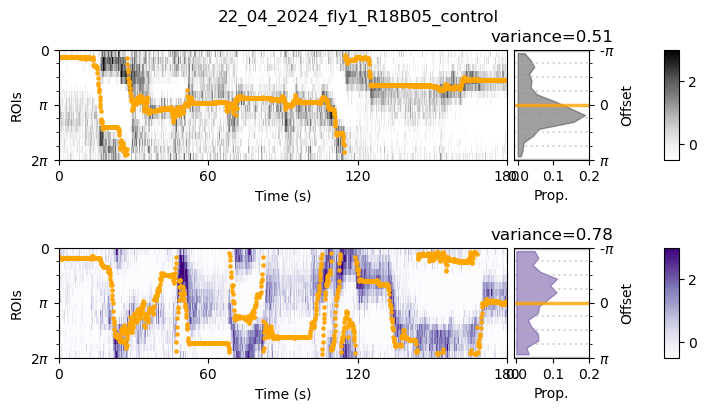

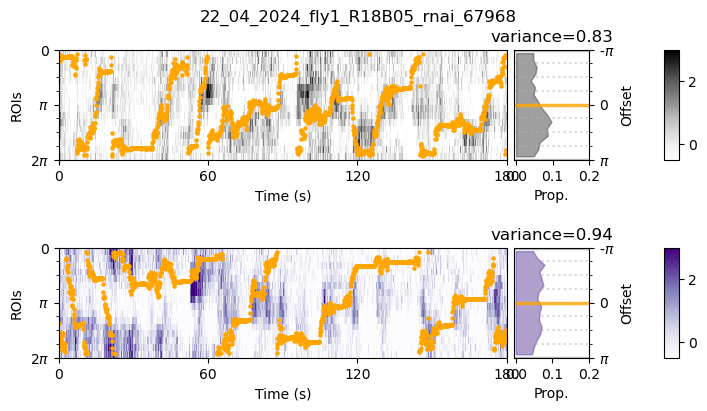

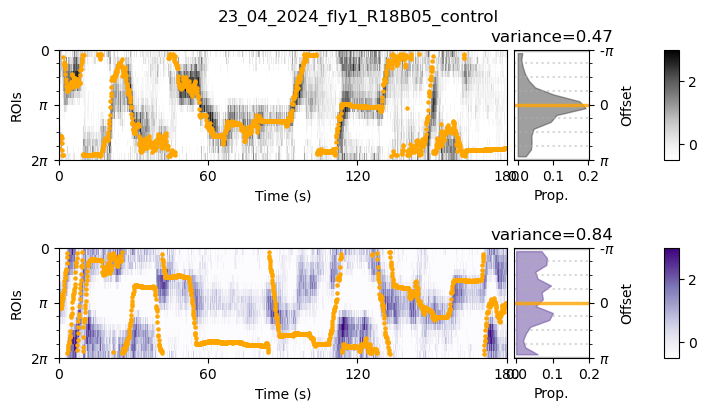

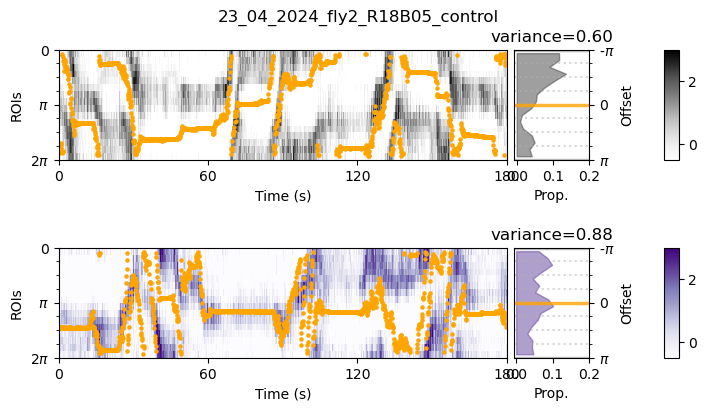

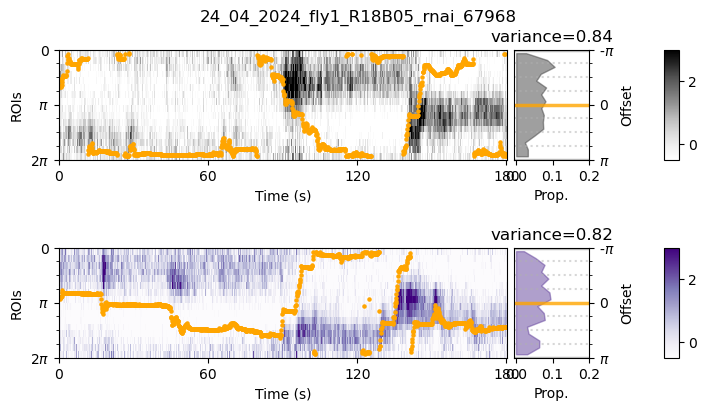

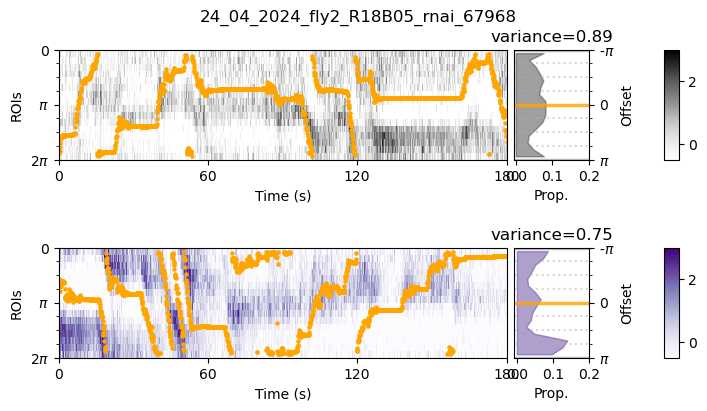

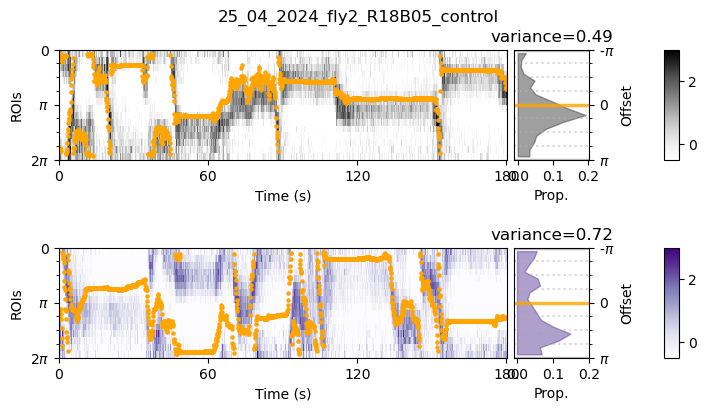

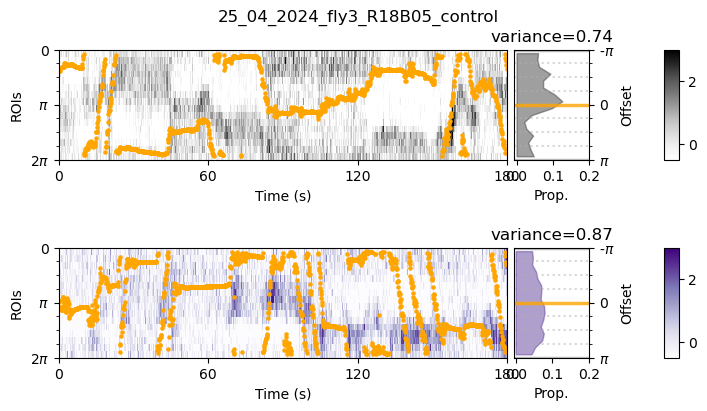

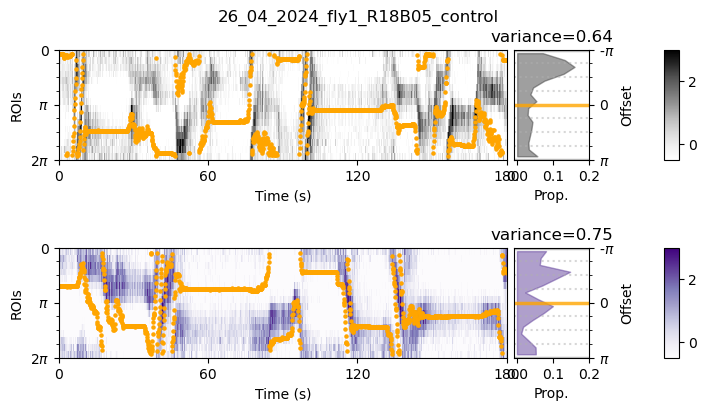

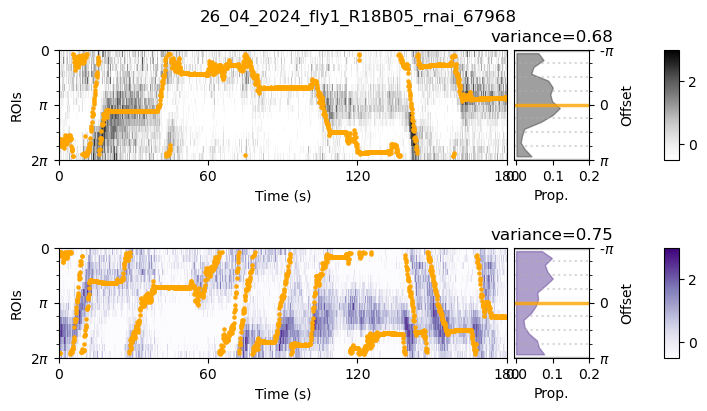

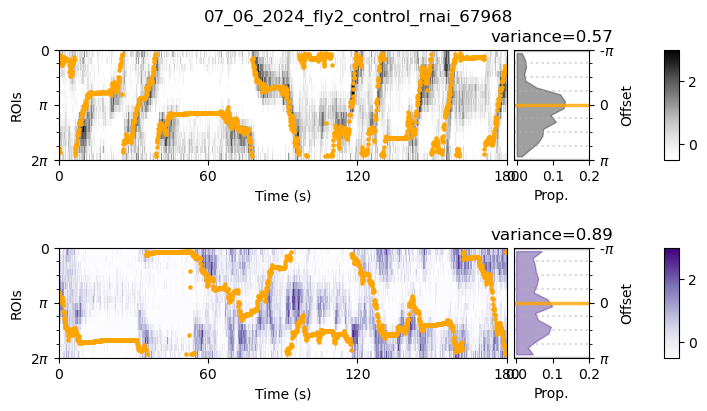

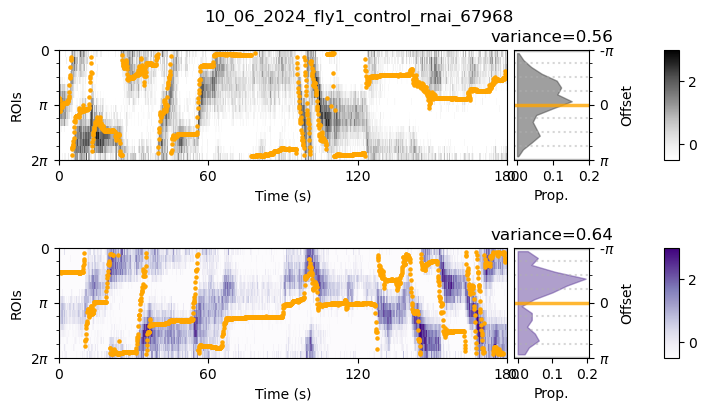

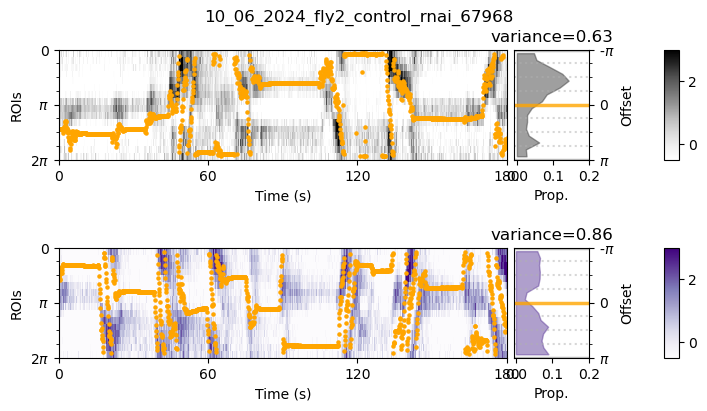

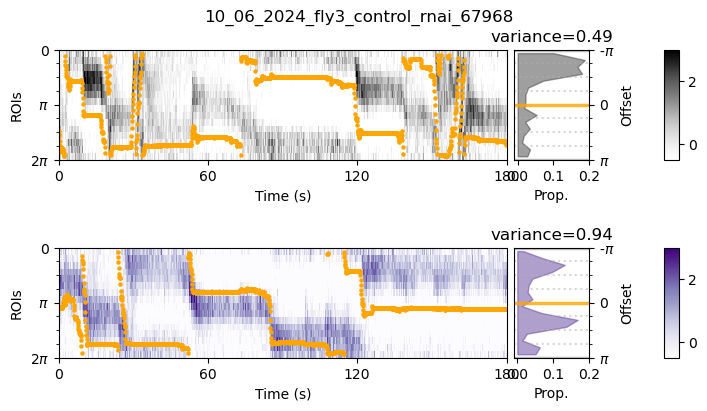

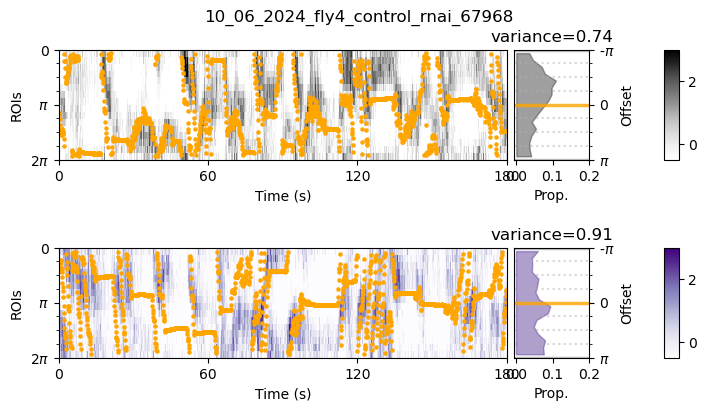

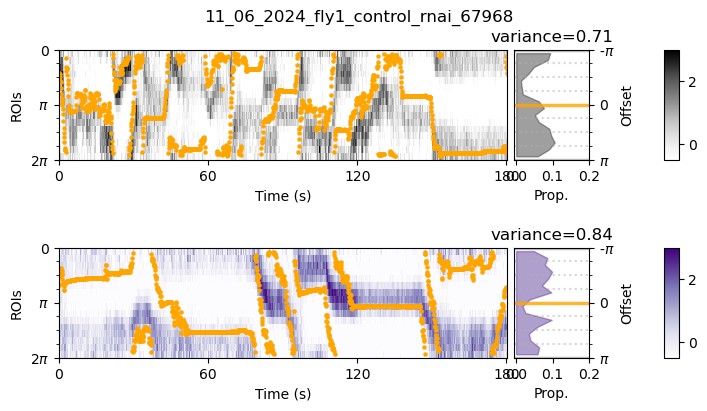

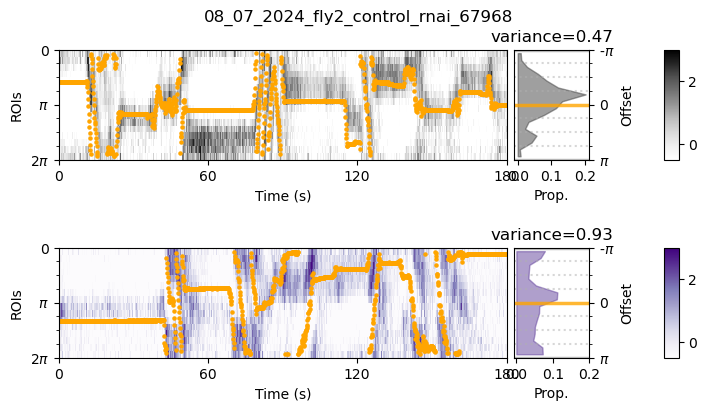

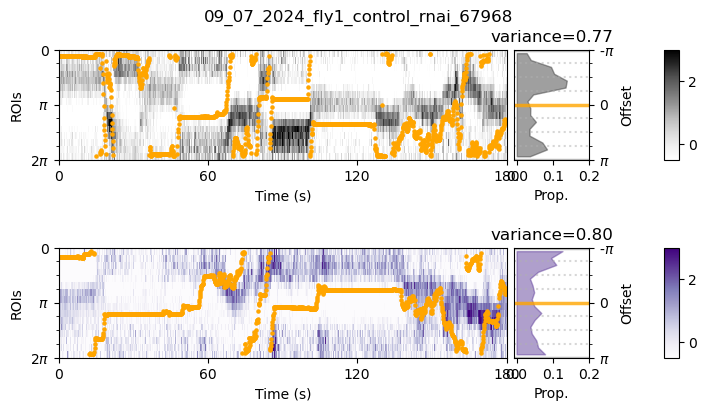

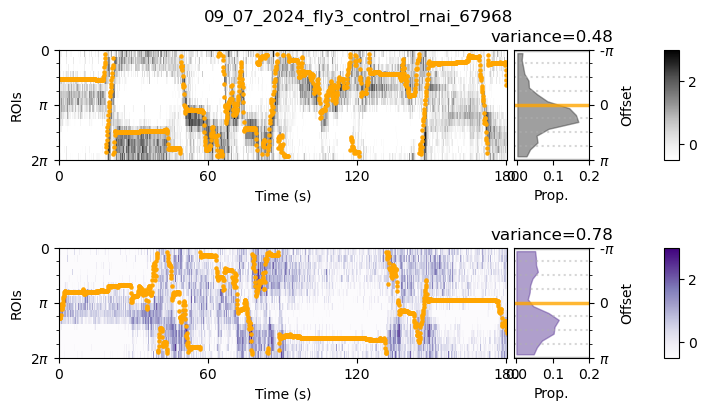

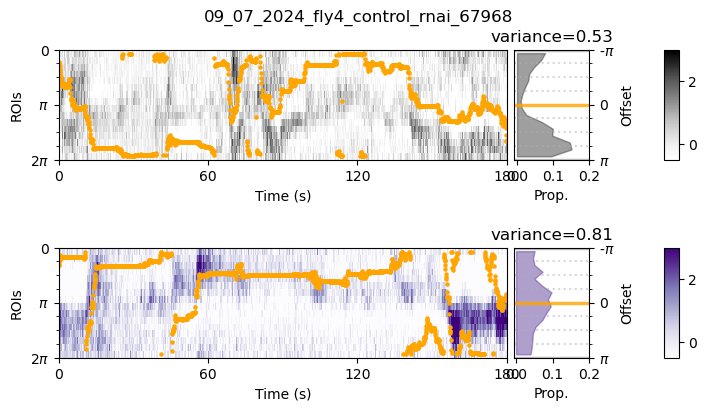

In [25]:
# plot each fly
session_folder = figfolder / "sessions"
session_folder.mkdir(parents=True, exist_ok=True)

flies = sess_df['fly_id'].unique()
for fly in flies:
    
    cl = sess_df.loc[(sess_df['fly_id']==fly) * (sess_df['closed_loop']>1)]
    dark = sess_df.loc[(sess_df['fly_id']==fly) * (sess_df['dark']==1)]
    
    if cl.shape[0]>0 and dark.shape[0]>0:
        
        ts_dict = {'fly': fly,
                   'closed_loop': nmp.session.GetTS(load_row(cl.iloc[0])),
                   'dark': nmp.session.GetTS(load_row(dark.iloc[0])),
        }
        
        fig_heatmaps, ax_heatmas = nmp.tbh_rnai.plot_sess_heatmaps_w_hist(ts_dict, twindow=[0,180.1])
        # fig_heatmaps, ax_heatmas = nmp.tbh_rnai.plot_sess_heatmaps(ts_dict)
        # (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.tbh_rnai.plot_sess_histograms(ts_dict)
    
    
    fly_folder = session_folder / fly
    fly_folder.mkdir(parents=True, exist_ok=True)
    
    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf")
    # fig_hist.savefig(fly_folder / "offset_hist.pdf")
    # fig_polar.savefig(fly_folder / "offset_polar.pdf")